<a href="https://colab.research.google.com/github/MathewBiddle/ioos_metrics/blob/main/GTS_Totals_weather_act.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IOOS GTS Statistics

Created: 2020-10-10

Updated: 2022-07-26

The Global Telecommunication System (GTS) is a coordinated effort for rapid distribution of observations.
The GTS monthly reports show the number of messages released to GTS for each station.
The reports contain the following fields:

- location ID: Identifier that station messages are released under to the GTS;
- region: Designated IOOS Regional Association (only for IOOS regional report);
- sponsor: Organization that owns and maintains the station;
- Met: Total number of met messages released to the GTS
- Wave: Total number of wave messages released to the GTS

In this notebook we will explore the statistics of the messages IOOS is releasing to GTS.

## Using this notebook

1. Pick the appropriate date range of interest.
1. Edit the variables `start_date` and `end_date` in the cell below to reflect your time period of interest (use `YYYY-MM-DD` format).
1. Run all the cells in the notebook.

The first step is to pick the appropriate date range of interest.

In [ ]:
start_date = "2018-01-01"
end_date = "2023-05-15"

IOOS has added the csv files to https://erddap.ioos.us/erddap/search/index.html?page=1&itemsPerPage=1000&searchFor=GTS

Source data can be found at NDBC ioosstats server that [hosts the CSV files](https://www.ndbc.noaa.gov/ioosstats/) with the ingest data.

In [2]:
import pandas as pd


url_ioos = 'https://erddap.ioos.us/erddap/tabledap/gts_regional_statistics.csvp'
df_ioos = pd.read_csv(url_ioos,parse_dates=[2])
df_ioos['source'] = 'IOOS'

url_ndbc = 'https://erddap.ioos.us/erddap/tabledap/gts_ndbc_statistics.csvp'
df_ndbc = pd.read_csv(url_ndbc,parse_dates=[2])
df_ndbc['source'] = 'NDBC'

url_nonndbc = 'https://erddap.ioos.us/erddap/tabledap/gts_non_ndbc_statistics.csvp'
df_nonndbc = pd.read_csv(url_nonndbc,parse_dates=[2])
df_nonndbc['source'] = 'non-NDBC'

df_out = pd.concat([df_ioos,df_ndbc,df_nonndbc])

df_out.sample(10)

,Year,Month,time (UTC),locationID,region,sponsor,met,wave,source
1478,2018,9,2018-09-01 00:00:00+00:00,44032,NERACOOS,NORTHEASTERN REGIONAL ASSN OF COASTAL OCEAN OB...,1366,1330,IOOS
23260,2021,10,2021-10-01 00:00:00+00:00,BWSF1,NaN,EVERGLADES NATIONAL PARK,0,0,non-NDBC
8594,2019,5,2019-05-01 00:00:00+00:00,44056,NaN,U.S. ARMY CORPS OF ENGINEERS,0,2620,non-NDBC
4845,2018,10,2018-10-01 00:00:00+00:00,PFXC1,NaN,NATIONAL OCEAN SERVICE,14538,0,non-NDBC
6628,2019,2,2019-02-01 00:00:00+00:00,44100,NaN,SCRIPPS WAVERIDER COASTAL DATA INFORMATION PRO...,0,2664,non-NDBC
3426,2019,12,2019-12-01 00:00:00+00:00,51000,NaN,NATIONAL WEATHER SERVICE,1440,1440,NDBC
1563,2018,10,2018-10-01 00:00:00+00:00,HBXC1,CeNCOOS,CENTRAL AND NORTHERN CALIFORNIA OCEAN OBSERVIN...,0,0,IOOS
11988,2019,12,2019-12-01 00:00:00+00:00,AGCM4,NaN,NATIONAL OCEAN SERVICE,14284,0,non-NDBC
11170,2019,11,2019-11-01 00:00:00+00:00,44062,NaN,CHESAPEAKE BAY INTERPRETIVE BUOY SYSTEM,6930,678,non-NDBC
24684,2021,12,2021-12-01 00:00:00+00:00,HIVT2,NaN,NOAA NOS PHYSICAL OCEANOGRAPHIC RT SYSTEM PROGRAM,14608,0,non-NDBC


# What's non-NDBC composed of?

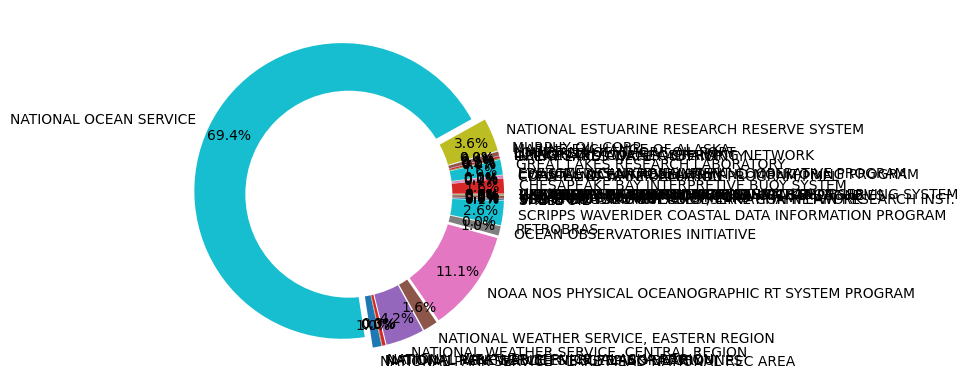

In [66]:
import matplotlib.pyplot as plt
import numpy as np


df_nonndbc['total'] = df_nonndbc['met'] + df_nonndbc['wave']
df_nonndbc["time (UTC)"] = df_nonndbc["time (UTC)"].dt.tz_localize(None)

nonndbc_group = df_nonndbc.groupby(by=['sponsor'])

grp = nonndbc_group[['met','wave','total']].sum()

grp_out = grp.assign(pcnt = grp['total'] / grp['total'].sum())

grp_out.loc[grp_out['pcnt']<0.05]

explode = 0.05*np.ones(len(grp_out))

grp_out['total'].plot.pie(rotatelabels=False,
                          autopct='%1.1f%%',
                          ylabel='',
                          textprops={'fontsize':10},
                          #radius=2,
                          pctdistance=0.85,
                          explode=explode)
# draw circle
centre_circle = plt.Circle((0, 0), 0.7, fc='white')
fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

#grp_out.sort_values(by='pcnt', ascending=False)

# Above chart is busy, let's group entries <2% into 'OTHER' category

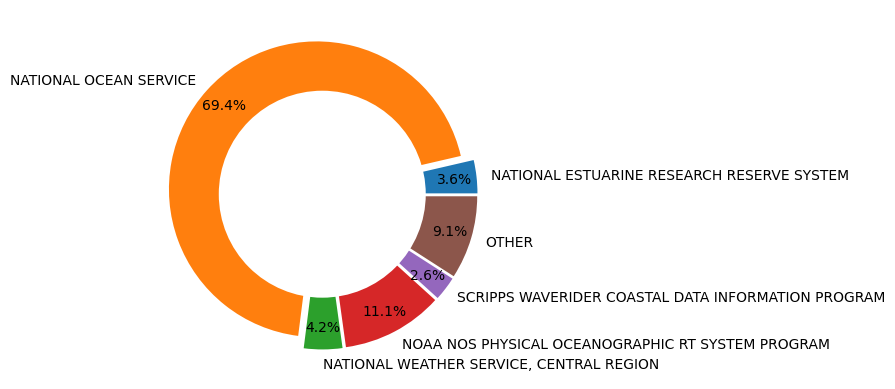

In [67]:
filtered_grp = grp_out.loc[grp_out['pcnt']>0.02]

filtered_grp.reset_index(inplace=True)

df = pd.DataFrame({'sponsor': 'OTHER',
              'total': [grp_out.loc[grp_out['pcnt']<0.02,'total'].sum()]
              })

df_pie = pd.concat([filtered_grp, df])

explode = 0.05*np.ones(len(df_pie))

df_pie.set_index('sponsor',inplace=True)

df_pie['total'].plot.pie(rotatelabels=False,
                          autopct='%1.1f%%',
                          ylabel='',
                          textprops={'fontsize':10},
                          #radius=2,
                          pctdistance=0.85,
                          explode=explode)
# draw circle
centre_circle = plt.Circle((0, 0), 0.7, fc='white')
fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

# print('Other:')
# grp_out.loc[grp_out['pcnt']<0.02].index.tolist()

What is 'OTHER'?

In [68]:
grp_out.loc[grp_out['pcnt']<0.02].index.tolist()

['ALASKA OCEAN OBSERVING SYSTEM',
 'BP INC.',
 'CARIBBEAN INTEGRATED COASTAL OCEAN OBSERVING SYSTEM',
 'CHESAPEAKE BAY INTERPRETIVE BUOY SYSTEM',
 'CLEVELAND WATER ALLIANCE',
 'COASTAL DATA INFORMATION PROGRAM/PMEL',
 'COASTAL OCEAN RESEARCH AND MONITORING PROGRAM',
 'EPA & MEXICAN GOVERNMENT COOPERATIVE PROGRAM',
 'EVERGLADES NATIONAL PARK',
 'GREAT LAKES RESEARCH LABORATORY',
 'GREAT LAKES WATER AUTHORITY',
 'ILLINOIS-INDIANA SEA GRANT',
 'INTEGRATED CORAL OBSERVING NETWORK',
 'LIMNOTECH',
 'LOUISIANA OFFSHORE OIL PORT',
 'MARINE EXCHANGE OF ALASKA',
 'MOSS LANDING MARINE LABORATORIES',
 'MURPHY OIL CORP.',
 'NATIONAL PARK SERVICE - LAKE MEAD NATIONAL REC AREA',
 'NATIONAL PARK SERVICES - SLEEPING BEAR DUNES',
 'NATIONAL RENEWABLE ENERGY LABORATORY',
 'NATIONAL WEATHER SERVICE, ALASKA REGION',
 'NATIONAL WEATHER SERVICE, EASTERN REGION',
 'OCEAN OBSERVATORIES INITIATIVE',
 'PETROBRAS',
 'SHELL OIL',
 'STONY BROOK UNIVERSITY',
 'SUNY PLATTSBURGH CEES / LAKE CHAMPLAIN RESEARCH INST.',


# What's NDBC composed of?

                                      met     wave     total      pcnt
sponsor                                                               
NATIONAL WEATHER SERVICE         40048696  7995722  48044418  0.958367
NATIONAL HURRICANE CENTER          915250   173158   1088408  0.021711
U. S. COAST GUARD                  456192   246322    702514  0.014013
CORPS OF ENGINEERS                 196298    62876    259174  0.005170
NDBC ENGINEERING                    14050     6698     20748  0.000414
NATIONAL ACADEMY OF SCIENCES         7918     1306      9224  0.000184
GREAT LAKES RESEARCH LABORATORY      2400     2324      4724  0.000094
NATIONAL DATA BUOY CENTER            1180     1180      2360  0.000047


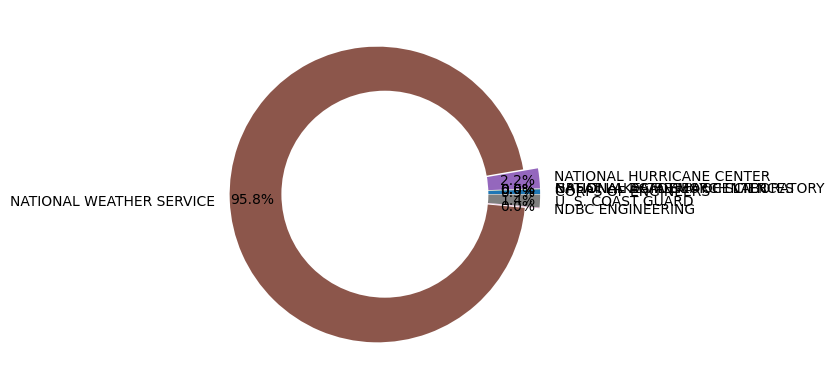

In [63]:
df_ndbc['total'] = df_ndbc['met'] + df_ndbc['wave']
df_ndbc["time (UTC)"] = df_ndbc["time (UTC)"].dt.tz_localize(None)

ndbc_group = df_ndbc.groupby(by=['sponsor'])

grp = ndbc_group[['met','wave','total']].sum()

grp_out = grp.assign(pcnt = grp['total'] / grp['total'].sum())

print(grp_out.sort_values(by='pcnt', ascending=False))

explode = 0.05*np.ones(len(grp_out))

grp_out['total'].plot.pie(rotatelabels=False,
                          autopct='%1.1f%%',
                          ylabel='',
                          textprops={'fontsize':10},
                          #radius=2,
                          pctdistance=0.85,
                          explode=explode)
# draw circle
centre_circle = plt.Circle((0, 0), 0.7, fc='white')
fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

# What's IOOS composed of?

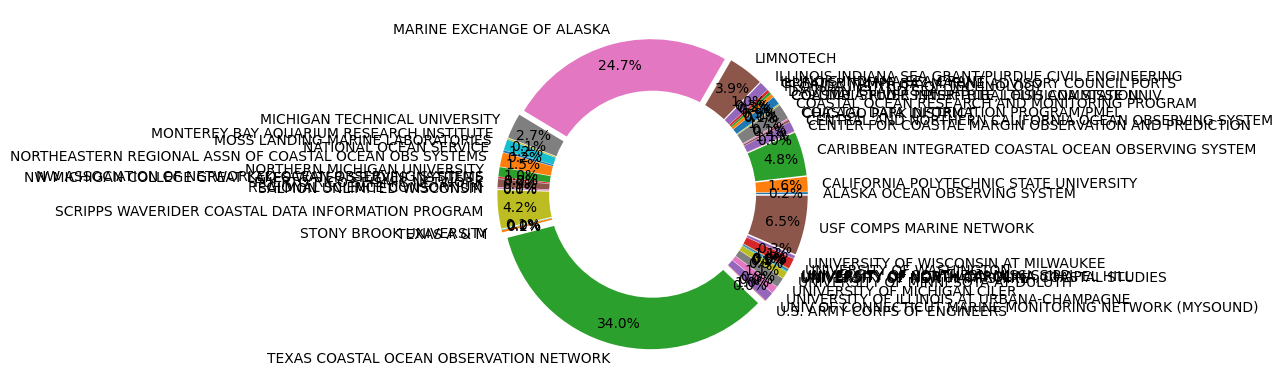

In [64]:
df_ioos['total'] = df_ioos['met'] + df_ioos['wave']
df_ioos["time (UTC)"] = df_ioos["time (UTC)"].dt.tz_localize(None)

ioos_group = df_ioos.groupby(by=['sponsor'])

grp = ioos_group[['met','wave','total']].sum()

grp_out = grp.assign(pcnt = grp['total'] / grp['total'].sum())

#print(grp_out.sort_values(by='pcnt', ascending=False))

explode = 0.05*np.ones(len(grp_out))

grp_out['total'].plot.pie(rotatelabels=False,
                          autopct='%1.1f%%',
                          ylabel='',
                          textprops={'fontsize':10},
                          #radius=2,
                          pctdistance=0.85,
                          explode=explode)
# draw circle
centre_circle = plt.Circle((0, 0), 0.7, fc='white')
fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

# Chart above is busy, let's make 'OTHER' category

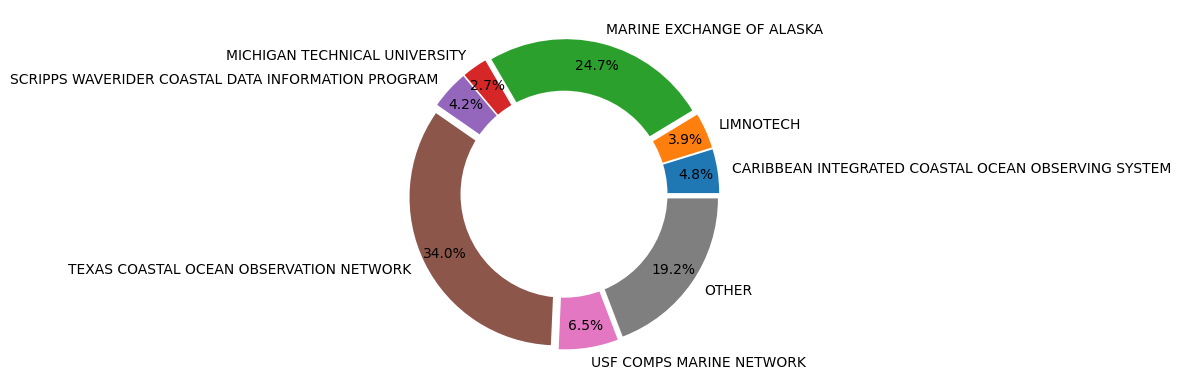

In [65]:
filtered_grp = grp_out.loc[grp_out['pcnt']>0.02]

filtered_grp.reset_index(inplace=True)

df = pd.DataFrame({'sponsor': 'OTHER',
              'total': [grp_out.loc[grp_out['pcnt']<0.02,'total'].sum()]
              })

df_pie = pd.concat([filtered_grp, df])

explode = 0.05*np.ones(len(df_pie))

df_pie.set_index('sponsor',inplace=True)

df_pie['total'].plot.pie(rotatelabels=False,
                          autopct='%1.1f%%',
                          ylabel='',
                          textprops={'fontsize':10},
                          #radius=2,
                          pctdistance=0.85,
                          explode=explode)
# draw circle
centre_circle = plt.Circle((0, 0), 0.7, fc='white')
fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

What is 'OTHER'?

In [58]:
grp_out.loc[grp_out['pcnt']<0.02].index.tolist()

['ALASKA OCEAN OBSERVING SYSTEM',
 'CALIFORNIA POLYTECHNIC STATE UNIVERSITY',
 'CENTER FOR COASTAL MARGIN OBSERVATION AND PREDICTION',
 'CENTRAL AND NORTHERN CALIFORNIA OCEAN OBSERVING SYSTEM',
 'CHICAGO PARK DISTRICT',
 'COASTAL DATA INFORMATION PROGRAM/PMEL',
 'COASTAL OCEAN RESEARCH AND MONITORING PROGRAM',
 'COASTAL STUDIES INSTITUTE, LOUISIANA STATE UNIV.',
 'COLUMBIA RIVER INTER-TRIBAL FISH COMMISSION',
 'DAUPHIN ISLAND SEA LAB',
 'FLORIDA INSTITUTE OF TECHNOLOGY',
 'GREATER TAMPA BAY MARINE ADVISORY COUNCIL PORTS',
 'ILLINOIS-INDIANA SEA GRANT',
 'ILLINOIS-INDIANA SEA GRANT/PURDUE CIVIL ENGINEERING',
 'MONTEREY BAY AQUARIUM RESEARCH INSTITUTE',
 'MOSS LANDING MARINE LABORATORIES',
 'NATIONAL OCEAN SERVICE',
 'NORTHEASTERN REGIONAL ASSN OF COASTAL OCEAN OBS SYSTEMS',
 'NORTHERN MICHIGAN UNIVERSITY',
 'NW ASSOCIATION OF NETWORKED OCEAN OBSERVING SYSTEMS',
 'NW MICHIGAN COLLEGE GREAT LAKES WATER STUDIES INSTITUTE',
 'PUERTO RICO SEISMIC NETWORK',
 'REGIONAL SCIENCE CONSORTIUM',
 'S

Let us check the monthly sum of data released both for individual met and wave and the totals.

In [ ]:
import pandas as pd

df_out["time (UTC)"] = df_out["time (UTC)"].dt.tz_localize(None)

groups = df_out[['time (UTC)','met','wave']].groupby(pd.Grouper(key="time (UTC)", freq="M"))

<Axes: xlabel='time (UTC)'>

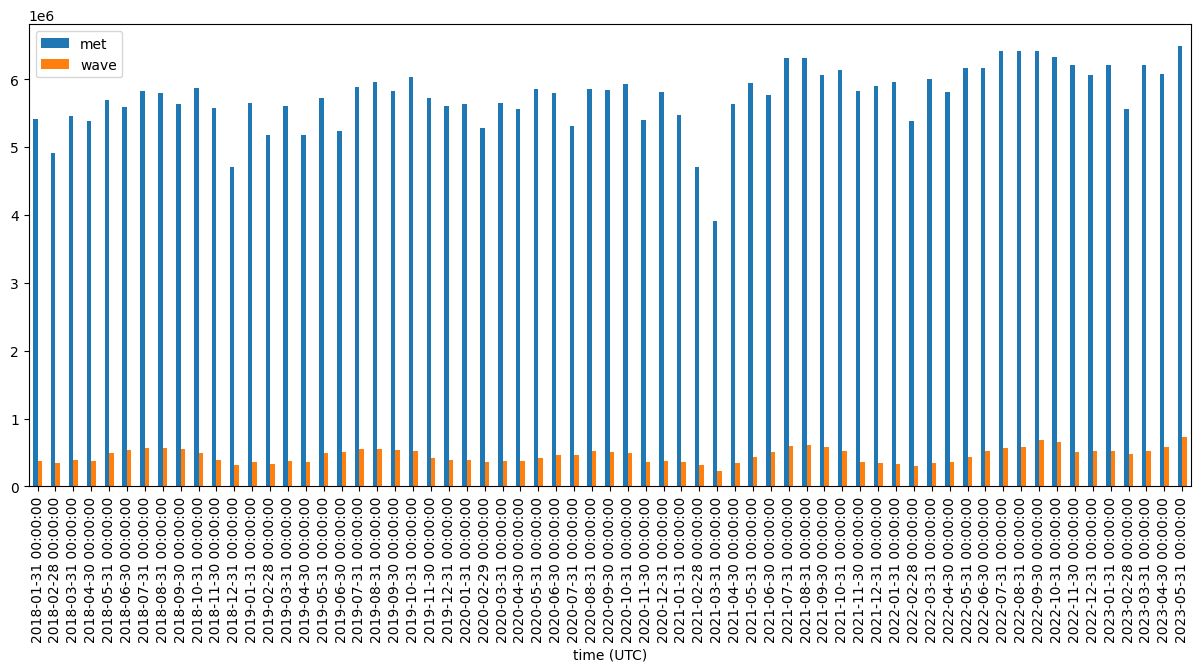

In [ ]:
groups.sum().plot(kind='bar',figsize=(15,6))

We can create a table of observations per month,

In [ ]:
s = groups[
    [ "met", "wave"]
].sum()  # reducing the columns so the summary is digestable
totals = s.assign(total=s["met"] + s["wave"])
totals.index = totals.index.to_period("M")

print(f"Monthly totals:\n{totals}\n")

print(
    f"Sum for time period {totals.index.min()} to {totals.index.max()}: {totals['total'].sum()}"
)

Monthly totals:
                met    wave    total
time (UTC)                          
2018-01     5416106  368948  5785054
2018-02     4906308  337780  5244088
2018-03     5454492  382206  5836698
2018-04     5388108  379066  5767174
2018-05     5696122  490110  6186232
...             ...     ...      ...
2023-01     6205396  528242  6733638
2023-02     5568626  476792  6045418
2023-03     6205058  518026  6723084
2023-04     6084730  572760  6657490
2023-05     6485208  730334  7215542

[65 rows x 3 columns]

Sum for time period 2018-01 to 2023-05: 402935928


and visualize it in a bar chart.

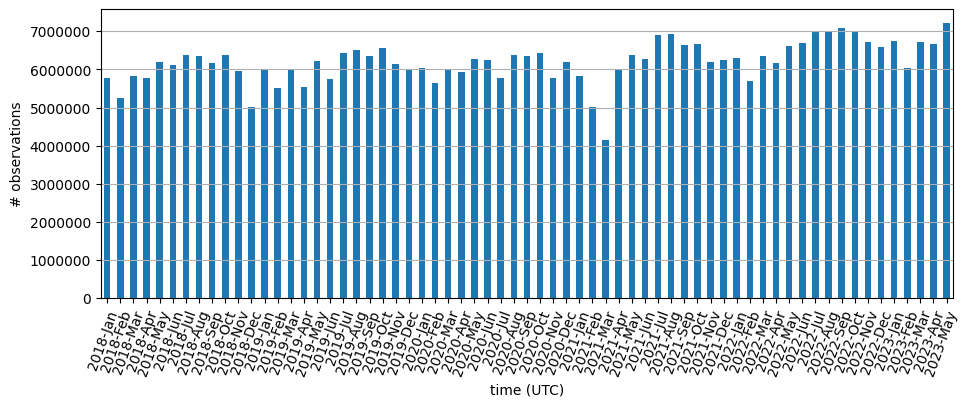

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(11, 3.75))

totals['total'].plot(ax=ax, kind="bar",stacked=True)
ax.set_xticklabels(
    labels=s.index.to_series().dt.strftime("%Y-%b"),
    rotation=70,
    rotation_mode="anchor",
    ha="right",
)
ax.yaxis.get_major_formatter().set_scientific(False)
ax.set_ylabel("# observations")
ax.grid(axis='y')

Group by source, then by month

In [ ]:
group = df_out.groupby(by=['source', pd.Grouper(key="time (UTC)", freq="M")])


s = group[
    ["met", "wave"]
].sum()  # reducing the columns so the summary is digestable

totals = s.assign(total=s["met"] + s["wave"])

totals.reset_index(['source'], inplace=True)

totals.index = totals.index.to_period("M").strftime('%Y-%b')

totals

,source,met,wave,total
time (UTC),,,,
2018-Jan,IOOS,701780,63624,765404
2018-Feb,IOOS,676688,61886,738574
2018-Mar,IOOS,759916,69014,828930
2018-Apr,IOOS,773482,75758,849240
2018-May,IOOS,890444,155768,1046212
...,...,...,...,...
2023-Jan,non-NDBC,4449714,219932,4669646
2023-Feb,non-NDBC,4029834,207298,4237132
2023-Mar,non-NDBC,4505624,232330,4737954


# Create stacked bar chart

IOOS + non-NDBC + NDBC

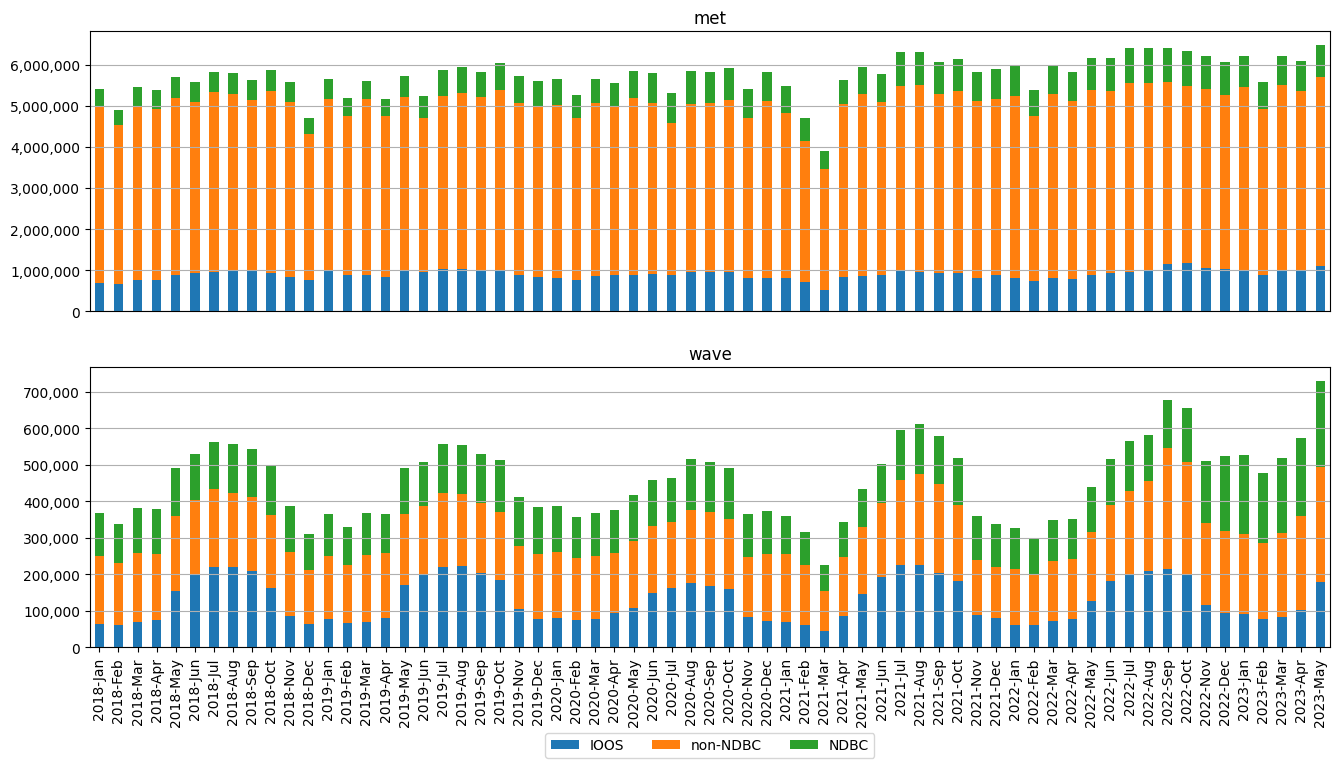

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator,
                               FuncFormatter)

fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(16,8))

df_met = pd.DataFrame({'IOOS': totals.loc[totals['source']=='IOOS','met'],
                         'non-NDBC': totals.loc[totals['source']=='non-NDBC','met'],
                         'NDBC': totals.loc[totals['source']=='NDBC','met'],
                         },
                         index= totals.index.unique())

df_met.plot.bar(stacked=True, xlabel='', ax=axs[0], rot=90, title='met')

axs[0].get_legend().remove()

axs[0].grid(axis='y')

axs[0].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
axs[0].axes.get_xaxis().set_visible(False)

df_wave = pd.DataFrame({'IOOS': totals.loc[totals['source']=='IOOS','wave'],
                         'non-NDBC': totals.loc[totals['source']=='non-NDBC','wave'],
                         'NDBC': totals.loc[totals['source']=='NDBC','wave'],
                         },
                         index= totals.index.unique())

df_wave.plot.bar(stacked=True, xlabel='', ax=axs[1], title='wave')

axs[1].legend(loc='center',bbox_to_anchor=(0.5,-0.35,0,0),ncol=3)

axs[1].grid(axis='y')

axs[1].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

In [ ]:
df_total = df_met + df_wave
df_total

,IOOS,non-NDBC,NDBC
time (UTC),,,
2018-Jan,765404,4488860,530790
2018-Feb,738574,4028584,476930
2018-Mar,828930,4423008,584760
2018-Apr,849240,4333812,584122
2018-May,1046212,4502094,637926
...,...,...,...
2023-Jan,1093098,4669646,970894
2023-Feb,962812,4237132,845474
2023-Mar,1080014,4737954,905116


# Create stacked chart

IOOS + non-IOOS (non-NDBC + NDBC)

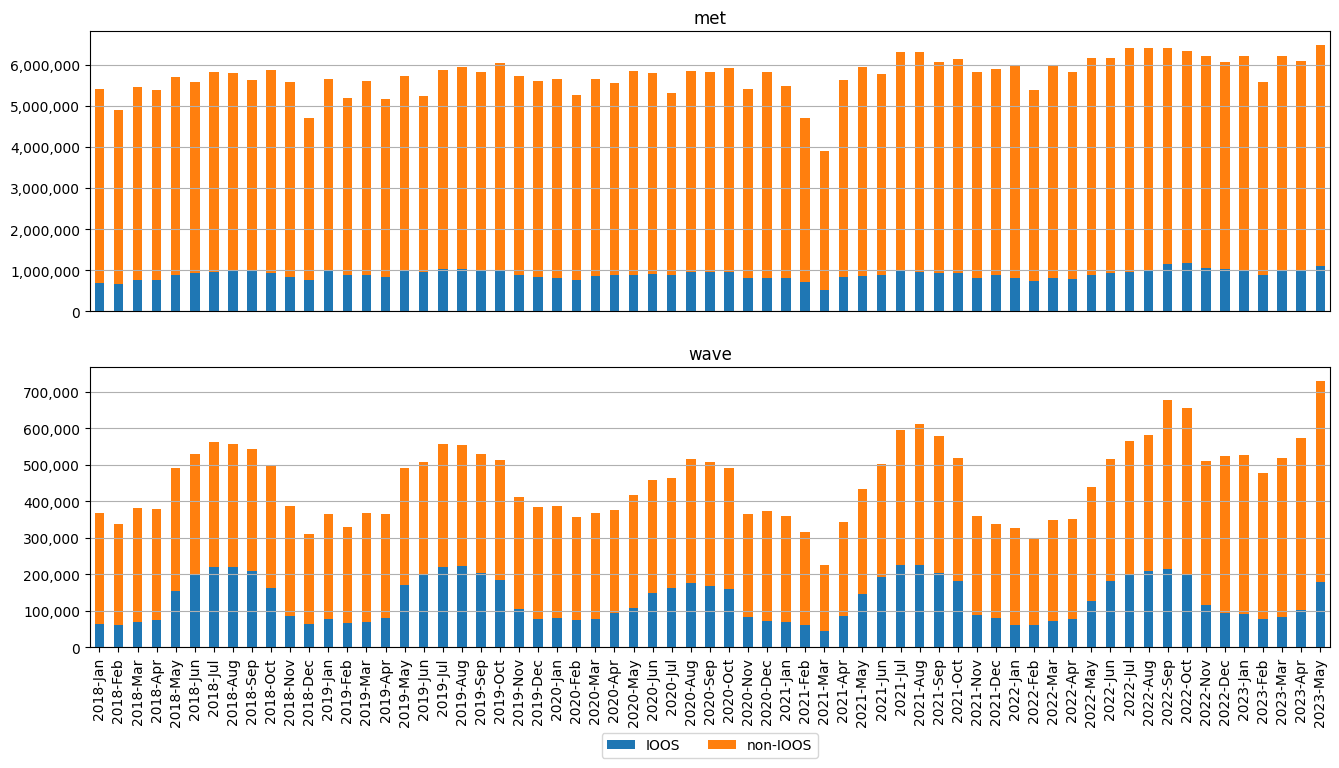

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator,
                               FuncFormatter)

color = {'IOOS':'C0',
         'non-IOOS': 'C1'}

fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(16,8))

df_met = pd.DataFrame({'IOOS': totals.loc[totals['source']=='IOOS','met'],
                       'non-IOOS': totals.loc[totals['source']=='NDBC','met']+totals.loc[totals['source']=='non-NDBC','met'],
                         },
                         index= totals.index.unique())

df_met.plot.bar(stacked=True,
                  xlabel='',
                  ax=axs[0],
                  rot=90,
                  title='met',
                  color=color)

axs[0].get_legend().remove()

axs[0].grid(axis='y')

axs[0].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
axs[0].axes.get_xaxis().set_visible(False)

df_wave = pd.DataFrame({'IOOS': totals.loc[totals['source']=='IOOS','wave'],
                         'non-IOOS': totals.loc[totals['source']=='NDBC','wave']+totals.loc[totals['source']=='non-NDBC','wave'],
                         },
                         index= totals.index.unique())

df_wave.plot.bar(
    stacked=True,
    xlabel='',
    ax=axs[1],
    title='wave',
    color=color)

axs[1].legend(loc='center',
              bbox_to_anchor=(0.5,-0.35,0,0),
              ncol=3)

axs[1].grid(axis='y')

axs[1].yaxis.set_major_formatter(
    FuncFormatter(lambda x, p: format(int(x), ','))
    )


co-ops = non-ndbc['NATIONAL OCEAN SERVICE'] + non-ndbc['NOAA NOS PHYSICAL OCEANOGRAPHIC RT SYSTEM PROGRAM']

ioos-regional = ioos_regional['met'] +ioos_regional['wave']

nerrs = non-ndbc['NATIONAL ESTUARINE RESEARCH RESERVE SYSTEM']

other = ndbc['total'] + non-ndbc NWS-regional + CBIBS + National Park Service + USACE (not including CDIP stations owned by RAs) + all other NDBC partners (including nonfederal partners outside of IOOS).
 anything not Ocean Service


Ocean Service contributions compared to the total.

split into met and wave

# NOS & non-NOS

In [ ]:
df_out['LO']=pd.Series(dtype=str)
df_out.loc[df_out['sponsor']=='NATIONAL OCEAN SERVICE','LO'] = 'NOS'
df_out.loc[df_out['sponsor']=='NOAA NOS PHYSICAL OCEANOGRAPHIC RT SYSTEM PROGRAM','LO'] = 'NOS'
df_out.loc[df_out['source']=='IOOS','LO'] = 'NOS'

df_out.loc[df_out['LO'].isna(),'LO'] = 'non-NOS'

What are we classifying as non-NOS?

In [ ]:
df_out.loc[df_out['LO']=='non-NOS','sponsor'].unique().tolist()

['CORPS OF ENGINEERS',
 'NATIONAL HURRICANE CENTER',
 'NATIONAL WEATHER SERVICE',
 'U. S. COAST GUARD',
 nan,
 'NDBC ENGINEERING',
 'NATIONAL DATA BUOY CENTER',
 'GREAT LAKES RESEARCH LABORATORY',
 'NATIONAL ACADEMY OF SCIENCES',
 'BP INC.',
 'EPA & MEXICAN GOVERNMENT COOPERATIVE PROGRAM',
 'CHESAPEAKE BAY INTERPRETIVE BUOY SYSTEM',
 'SCRIPPS WAVERIDER COASTAL DATA INFORMATION PROGRAM',
 'EVERGLADES NATIONAL PARK',
 'INTEGRATED CORAL OBSERVING NETWORK',
 'LOUISIANA OFFSHORE OIL PORT',
 'MOSS LANDING MARINE LABORATORIES',
 'NATIONAL ESTUARINE RESEARCH RESERVE SYSTEM',
 'NATIONAL PARK SERVICE - LAKE MEAD NATIONAL REC AREA',
 'NATIONAL RENEWABLE ENERGY LABORATORY',
 'NATIONAL WEATHER SERVICE, ALASKA REGION',
 'NATIONAL WEATHER SERVICE, CENTRAL REGION',
 'NATIONAL WEATHER SERVICE, EASTERN REGION',
 'OCEAN OBSERVATORIES INITIATIVE',
 'PETROBRAS',
 'SHELL OIL',
 'U.S. ARMY CORPS OF ENGINEERS',
 'WOODS HOLE OCEANOGRAPHIC INSTITUTION',
 'VERMONT EPSCOR',
 'NATIONAL PARK SERVICES - SLEEPING BEA

## Group by the new LO column

In [ ]:
group = df_out.groupby(by=['LO', pd.Grouper(key="time (UTC)", freq="M")])

s = group[
    ["met", "wave"]
].sum()  # reducing the columns so the summary is digestable

totals = s.assign(total=s["met"] + s["wave"])

totals.reset_index(['LO'], inplace=True)

totals.index = totals.index.to_period("M").strftime('%Y-%b')

totals

,LO,met,wave,total
time (UTC),,,,
2018-Jan,NOS,4350064,63624,4413688
2018-Feb,NOS,3947286,61886,4009172
2018-Mar,NOS,4360558,69014,4429572
2018-Apr,NOS,4290340,75758,4366098
2018-May,NOS,4530964,155768,4686732
...,...,...,...,...
2023-Jan,non-NOS,1455770,437976,1893746
2023-Feb,non-NOS,1302562,399200,1701762
2023-Mar,non-NOS,1411344,435908,1847252


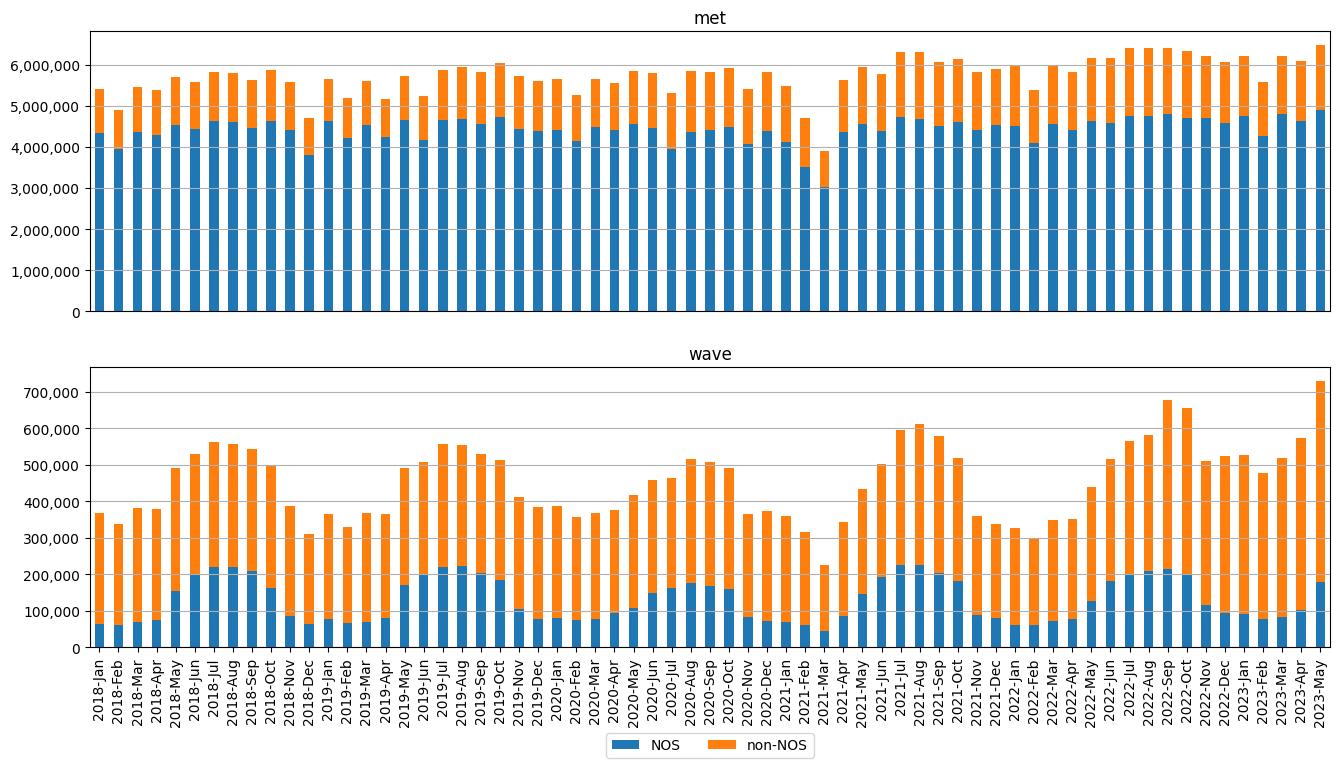

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator,
                               FuncFormatter)


color = {'NOS':'C0',
         'non-NOS': 'C1'}

fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(16,8))


# first chart
df_met = pd.DataFrame({'NOS': totals.loc[totals['LO']=='NOS','met'],
                         'non-NOS': totals.loc[totals['LO']=='non-NOS','met'],
                         'nos-percent':totals.loc[totals['LO']=='NOS','met'] / (totals.loc[totals['LO']=='NOS','met'] + totals.loc[totals['LO']=='non-NOS','met'])
                         },
                         index= totals.index.unique())

bar = df_met[['NOS','non-NOS']].plot.bar(stacked=True, xlabel='', ax=axs[0], rot=90, title='met', color=color)

axs[0].get_legend().remove()

axs[0].grid(axis='y')

axs[0].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
axs[0].axes.get_xaxis().set_visible(False)
#axs[0].bar_label(bar,df_wave['percent'])


# second chart
df_wave = pd.DataFrame({'NOS': totals.loc[totals['LO']=='NOS','wave'],
                         'non-NOS': totals.loc[totals['LO']=='non-NOS','wave'],
                         'nos-percent':totals.loc[totals['LO']=='NOS','wave'] / (totals.loc[totals['LO']=='NOS','wave'] + totals.loc[totals['LO']=='non-NOS','wave'])
                         },
                         index= totals.index.unique())

df_wave[['NOS','non-NOS']].plot.bar(stacked=True, xlabel='', ax=axs[1], title='wave', color=color)

axs[1].legend(loc='center',bbox_to_anchor=(0.5,-0.35,0,0),ncol=3)

axs[1].grid(axis='y')

axs[1].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

In [ ]:
df_all = df_met + df_wave

df_all['nos-percent'] = df_all['NOS'] / (df_all['NOS'] + df_all['non-NOS'])

df_all

,NOS,non-NOS,nos-percent
time (UTC),,,
2018-Jan,4413688,1371366,0.762947
2018-Feb,4009172,1234916,0.764513
2018-Mar,4429572,1407126,0.758917
2018-Apr,4366098,1401076,0.757060
2018-May,4686732,1499500,0.757607
...,...,...,...
2023-Jan,4839892,1893746,0.718763
2023-Feb,4343656,1701762,0.718504
2023-Mar,4875832,1847252,0.725237


# Calculate the percent contributions per year

In [ ]:
all = df_all.reset_index()
all['time (UTC)'] = pd.to_datetime(all['time (UTC)'])
year_group = all.groupby(by=pd.Grouper(key="time (UTC)", freq="Y"))
s = year_group[['NOS','non-NOS']].sum()

year_totals = s.assign(nos_percent=s["NOS"] / ( s["NOS"]+ s["non-NOS"]))

year_totals.index = year_totals.index.to_period("M").strftime('%Y')

year_totals

,NOS,non-NOS,nos_percent
time (UTC),,,
2018,54063850,17153684,0.759137
2019,55582460,17399994,0.761587
2020,53539838,19468350,0.733340
2021,53032882,20170004,0.724464
2022,56699818,22449876,0.716362
2023,23889636,9485536,0.715791
